In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import category_encoders
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

% matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/samuelhopkins/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
orig_df = pd.read_csv('data/fars.csv')
print(orig_df.shape)
orig_df = orig_df.loc[orig_df.INJURY_SEVERITY.isin({'Fatal_Injury', 'No_Injury'})].copy()
orig_df['INJURY_SEVERITY'] = orig_df.INJURY_SEVERITY.map({'Fatal_Injury': 1, 'No_Injury': 0})
print(orig_df.shape)

(100968, 30)
(62123, 30)


In [3]:
random_state = 42

class Experiment:
    def __str__(self):
        return str((
            ('X_train', self.X_train.shape[0]),
            ('X_test', self.X_test.shape[0]),
            ('X_test_1', self.X_test_1.shape[0]),
            ('X_test_2', self.X_test_2.shape[0])
        ))
    
    def __repr__(self):
        return str(self)


def _create_splits(_df, exp, remove_from_train):
    exp.X_train, exp.X_test, exp.y_train, exp.y_test = train_test_split(
        _df.drop('INJURY_SEVERITY', axis=1),
        _df['INJURY_SEVERITY'],
        test_size=10000 - 100, # because of heroku limits,
        random_state=random_state
    )
    
    exp.X_train_after, exp.y_train_after = exp.X_train.copy(), exp.y_train.copy()
    
    half = round(exp.X_test.shape[0] / 2)
    exp.X_test_1, exp.y_test_1 = exp.X_test.iloc[:half].copy(), exp.y_test.iloc[:half].copy()
    exp.X_test_2, exp.y_test_2 = exp.X_test.iloc[half:].copy(), exp.y_test.iloc[half:].copy()
    
    for transformer in remove_from_train:
        remove_mask = transformer(exp.X_train_after)
        exp.X_train_after = exp.X_train_after.loc[~remove_mask].copy()
        exp.y_train_after = exp.y_train_after.loc[~remove_mask].copy()

        
def _make_pipeline():
    return make_pipeline(
        category_encoders.OrdinalEncoder(handle_unknown='ignore'),
        Imputer(strategy='mean'),
        RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=random_state),
    )
        
    
def _make_pipelines(exp):
    exp.base_pipeline = _make_pipeline()
    exp.retrained_pipeline = _make_pipeline()
    
    
def _run_benchmarks(exp):
    exp.base_pipeline.fit(exp.X_train_after.copy(), exp.y_train_after.copy())    
    exp.base_score = roc_auc_score(exp.y_test, exp.base_pipeline.predict_proba(exp.X_test)[:, 1])
    
    exp.retrained_pipeline.fit(
        pd.concat([exp.X_train, exp.X_test_1]),
        pd.concat([exp.y_train, exp.y_test_1])
    )
    
    retrained_predictions = pd.concat([
        pd.Series(exp.base_pipeline.predict_proba(exp.X_test_1)[:, 1]),
        pd.Series(exp.retrained_pipeline.predict_proba(exp.X_test_2)[:, 1])
    ])
    
    exp.retrained_score = roc_auc_score(exp.y_test, retrained_predictions)
    print(f'benchmark with no re-training: {exp.base_score}')
    print(f'benchmark with re-training: {exp.retrained_score}')

    
def plot_importances(exp, pipeline):
    pd.Series(
        pipeline.steps[-1][1].feature_importances_,
        index=exp.X_train_after.columns
    ).nlargest(15).plot.barh();
    
    
def run_experiment(_df=None, remove_from_train=None, exp=None):
    
    remove_from_train = remove_from_train or []
    if exp is None:
        exp = Experiment()
        _create_splits(_df, exp, remove_from_train)
    _make_pipelines(exp)
    _run_benchmarks(exp)
    
    return exp

In [4]:
known_features = [
    'SEX',
    'PERSON_TYPE',
    'SEATING_POSITION',
    'NON_MOTORIST_LOCATION',
    'RELATED_FACTOR_(1)-PERSON_LEVEL',
    'RELATED_FACTOR_(2)-PERSON_LEVEL',
    'RELATED_FACTOR_(3)-PERSON_LEVEL',
    'INJURY_SEVERITY',
    'AGE'
]

In [7]:
exp1 = run_experiment(orig_df[known_features].copy())

benchmark with no re-training: 0.6768780969057535
benchmark with re-training: 0.6763456541331236


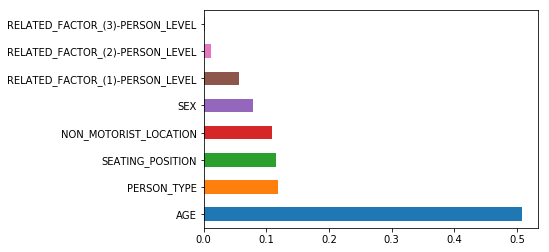

In [10]:
plot_importances(exp1, exp1.base_pipeline)

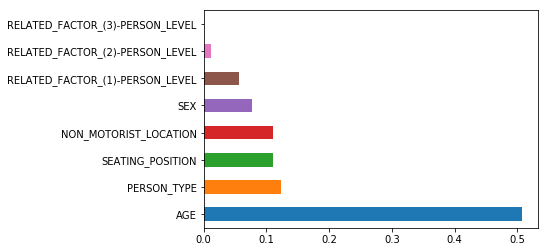

In [11]:
plot_importances(exp1, exp1.retrained_pipeline)

In [12]:
exp = exp_orig = run_experiment(
    orig_df[known_features].copy(),
    remove_from_train=[
        lambda _df: _df.AGE < 40,
        lambda _df: _df.AGE > 55,
        lambda _df: _df.SEATING_POSITION == 'Second_Seat_-_Right_Side',
        lambda _df: _df.SEATING_POSITION == 'Second_Seat_-_Left_Side',
        lambda _df: _df.SEATING_POSITION == 'Unknown',
    ]
)

benchmark with no re-training: 0.6030793778075982
benchmark with re-training: 0.6435684302932468


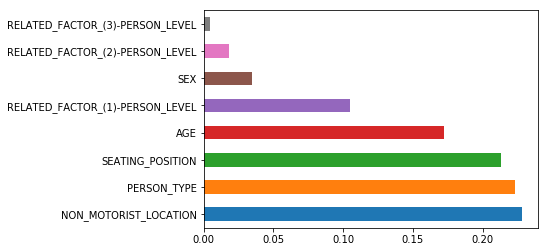

In [13]:
plot_importances(exp, exp.base_pipeline)

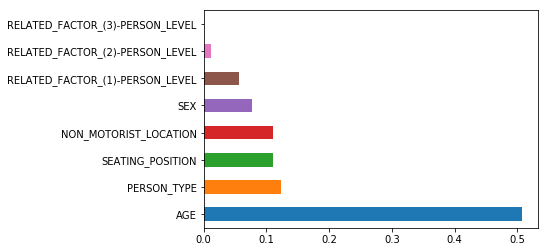

In [14]:
plot_importances(exp, exp.retrained_pipeline)

# Obfuscate and visual QA

In [15]:
obfuscation_mapping = {
    'PERSON_TYPE': {
         'Driver': 'driving',
         'Bicyclist': 'on_bike',
         'Passenger_of_a_Motor_Vehicle_in_Transport': 'passenger',
         'Pedestrian': 'on_foot',
         'Other_Pedestrian': 'other_on_foot',
         'Occupant_of_a_Motor_Vehicle_Not_in_Transport': 'in_stopped_vehicle',
         'Unknown_Occupant_Type_in_a_Motor_Vehicle_in_Transport': 'unknown_in_vehicle',
         'Occupant_of_a_Non-Motor_Vehicle_Transport_Device': 'unknown_in_other_vehicle_type',
         'Other_Cyclist': 'other_on_bike'
    },
    'SEATING_POSITION': {
        'Front_Seat_-_Left_Side_(Drivers_Side)': 'front_left',
         'Non-Motorist': 'not_in_vehicle',
         'Other_Passenger_in_enclosed_passenger_or_cargo_area': 'cargo_area',
         'Front_Seat_-_Right_Side': 'front_right',
         'Second_Seat_-_Right_Side': 'front_right_second',
         'Second_Seat_-_Left_Side': 'front_left_second',
         'Unknown': 'n/a',
         'Second_Seat_-_Middle': 'second_middle',
         'Front_Seat_-_Middle': 'front_middle',
         'Other_Passenger_in_unenclosed_passenger_or_cargo_area': 'cargo_open_area',
         'Riding_on_Vehicle_Exterior': 'riding_outside_of_vehicle',
         'Sleeper_Section_of_Cab_(Truck)': 'truck_cab_sleeper_area',
         'Third_Seat_-_Right_Side': 'third_right',
         'Third_Seat_-_Left_Side_(Drivers_Side)': 'third_left',
         'Front_Seat_-_Unknown': 'front_unknown',
         'Third_Seat_-_Other': 'other_third',
         'Second_Seat_-_Unknown': 'second_other',
         'Second_Seat_-_Other': 'second_unknown',
         'Third_Seat_-_Middle': 'middle_third',
         'Other_Passenger_in_passenger_or_cargo_area_(unknown_whether_or_not_enclosed)': 'cargo_area_unknown',
         'Front_Seat_-_Other': 'front_unknown',
         'Trailing_Unit': 'in_trailer',
         'Third_Seat_-_Unknown': 'third_unknown',
         'Fourth_Seat_-_Left_Side': 'fourth_left',
         'Fourth_Seat_-_Right_Side': 'fourth_right'
    },
    'NON_MOTORIST_LOCATION': {
         'Not_Applicable_-_Vehicle_Occupant': 'N/A',
         'Non-Intersection_-_On_Roadway_Crosswalk_not_Available': 'in_unmarked_intersection',
         'Intersection_-_In_Crosswalk': 'in_intersection_legal',
         'Non-Intersection_-_On_Roadway_Not_in_Crosswalk': 'middle_of_road',
         'Non-Intersection_-_On_Roadway_Crosswalk_Availability_Unknown': 'middle_of_road_unknown',
         'Intersection_-_On_Roadway_Crosswalk_Availability_Unknown': 'in_intersection_possible_xwalk',
         'Intersection_-_On_Roadway_Crosswalk_not_Available': 'in_intersection_no_xwalk',
         'Non-Intersection_-_Other_Not_a_Roadway': 'not_intersection_not_road',
         'Non-Intersection_-_Outside_Trafficway': 'not_intersection_no_highway',
         'Intersection_-_On_Roadway_Not_in_Crosswalk': 'on_roadway_intersection',
         'Non-Intersection_-_In_Crosswalk': 'xwalk_non_intersection',
         'Intersection_-_Unknown': 'intersection_unknown',
         'Non-Intersection_-_On_Road_Shoulder': 'roadside_not_intersection',
         'Non-Intersection_-_Unknown': 'not_known_not_intersection',
         'Unknown': 'unknown',
         'Intersection_-_Not_on_Roadway': 'not_highway_in_intersection',
         'Non-Intersection_-_Bike_Path': 'bike_path_not_intersection',
         'Non-Intersection_-_In_Parking_Lane': 'parking_lane_not_intersection'
    },
    'related_factors': {
         'Passed_OutBlackout': 'unconscious_or_too_krunk',
         'Curve_Hill_Or_Other_Design_Features_(including_Traffic_signs_Embankment)': 'curved_hill',
         'Mentally_Challenged': 'mentally_handicapped',
         'Head_Restraints_AVOIDING_SWERVING_OR_SLIDING_DUE_TO': 'wearing_functional_head_restraints',
         'Illegal_Driving_on_Road_Shoulder_in_Ditch_on_Sidewalk_on_Median': 'driving_on_roadside',
         'Walking_With_Cane_or_Crutches': 'using_cane',
         'Getting_Off/Out_of_or_On/In_to_Non-Moving_Transport_Vehicle': 'alighting_non_moving_vehicle',
         'Improper_Crossing_or_Roadway_or_Intersection': 'bad_crossing_or_intersection',
         'Mother_of_Dead_Fetus': 'mother_child_not_survived',
         'Animals_in_Road': 'squirrel_in_road',
         'Failure_to_Yield_Right_of_Way': 'failure_to_yield',
         'Interfering_with_Driver': 'was_tickling_driver',
         'Impaired_Due_to_Previous_Injury': 'has_previous_injury',
         'Making_Improper_Turn': 'making_illegal_turn',
         'Passing_on_Wrong_Side': 'passing_wrong_side',
         'Slippery_or_Loose_Surface': 'slippery_surface',
         'Operator_Inexperience': 'inexperienced_driver',
         'Construction/Maintenance/Utility_Worker': 'roadside_worker',
         'Getting_Off/Out_of_or_On/In_to_Moving_Transport_Vehicle': 'boarding_or_exiting_moving_vehicle',
         'Parked_Vehicle': 'vehicle_was_parked',
         'Driving_on_Wrong_Side_of_Road': 'driving_incorrect_side_of_road',
         'Failure_to_Keep_in_Proper_Lane': 'swerved_out_of_lane',
         'Driving_too_Fast_for_Conditions_or_in_Excess_of_Posted_Speed_Limit': 'speeding',
         'Improper_or_Erratic_Lane_Changing': 'erratic_lane_change',
         'Opening_Vehicle_Closure_into_Moving_Traffic_or_While_Vehicle_is_in_Motion': 'open_door_while_moving',
         'Inattentive_(talking_Eating_etc)': 'on_cellphone',
         'Passing_with_Insufficient_Distance_or_Inadequate_Visibility_or_Failing_to_Yield_to_Overtaking_Vehicle': 'was_doing_tide_challenge',
         'Motor_Vehicle_(including_load)': 'motor_vehicle',
         'Building_Billboard_or_Other_Structures': 'roadside_structure_construction_worker',
         'Not_Applicable_-_Driver/None_-_All_Other_Persons': 'N/A',
         'Failure_to_Observe_Warnings_or_Instructions_on_Vehicles_Displaying_Them': 'failure_observe_vehicle_warnings',
         'Traveling_on_Prohibited_Trafficway': 'traveling_on_closed_road',
         'Rain_Snow_Fog_Smoke_Sand_Dust': 'adverse_weather',
         'Ruts_Holes_Bumps_in_Road': 'potholes_in_road',
         'Trees_Crops_Vegetation': 'heavy_roadside_vegetation',
         'Failure_to_Obey_Traffic_Signs_Traffic_Control_Devices_or_Traffic_Officers_Failure_to_Observe_Safety_Zone_Traffic_Laws': 'traffic_law_broken',
         'Motorized_Wheelchair_Rider': 'uses_wheelchair',
         'Locked_Wheel': 'wheel_locked',
         'Reflected_Glare_Bright_Sunlight_Headlights': 'reflective_glare',
         'Not_Visible': 'not_visible',
         'Other_Physical_Impairment': 'physical_impairment',
         'Failing_to_Dim_Lights_or_Have_Lights_on_When_Required': 'failure_turn_lights_on',
         'Non-Motorist_Pushing_a_Vehicle': 'physically_pushing_vehicle',
         'Darting_Stumbling_or_Running_into_Road': 'ran_into_road',
         'Unknown': 'N/A or Unknown',
         'Operating_without_Required_Equipment': 'missing_legally_required_equipment',
         'Making_Improper_Entry_to_or_Exit_from_Trafficway': 'improper_entry_onto_highway',
         'Vision_obscured_by_overcorrecting': 'suboptimal_visibility',
         'Emotional_(e.g._Depression_Angry_Disputed)': 'recent_depression',
         'Following_Improperly': 'following_too_close',
         'Vehicle_in_Road': 'in_street',
         'Operating_the_Vehicle_in_Other_Erratic_Reckless_Careless_or_Negligent_Manner_[or_Operating_at_Erratic_or_Suddenly_Changing_Speeds': 'erratic_careless_behavior',
         'Restricted_to_Wheelchair': 'in_wheelchair',
         'Pedestrian_NON-MOTOR_VEHICLE_OPERATOR_RELATED_FACTORS:': 'ped_non_vehicle_operator',
         'Blind': 'sightless_or_blind',
         'Walking/Riding_with_or_Against_Traffic_Playing_Working_Sitting_Lying_Standing_etc._in_Roadway': 'pedestrial_in_middle_of_street'
    },
    'SEX': {
        'Male': 'm',
        'Female': 'f'
    }
}

obfuscation_mapping.update({
    'RELATED_FACTOR_(1)-PERSON_LEVEL': obfuscation_mapping['related_factors'],
    'RELATED_FACTOR_(2)-PERSON_LEVEL': obfuscation_mapping['related_factors'],
    'RELATED_FACTOR_(3)-PERSON_LEVEL': obfuscation_mapping['related_factors'],
})
del obfuscation_mapping['related_factors']

colmapping = {
    'PERSON_TYPE': 'person_attributes',
    'SEATING_POSITION': 'seat',
    'NON_MOTORIST_LOCATION': 'other_person_location',
    'RELATED_FACTOR_(1)-PERSON_LEVEL': 'other_factor_1',
    'RELATED_FACTOR_(2)-PERSON_LEVEL': 'other_factor_2',
    'RELATED_FACTOR_(3)-PERSON_LEVEL': 'other_factor_3',
    'SEX': 'm_or_f',
    'AGE': 'age_in_years',
}


In [16]:
def obfuscate(exp):
    
    datasets_to_obfuscate = [
        'X_train',
        'X_train_after',
        'X_test',
        'X_test_1',
        'X_test_2',
    ]
    
    def _apply_to_all(func):
        for attr in datasets_to_obfuscate:
            func(getattr(exp, attr))
    
    for colname, mappings in obfuscation_mapping.items():
        def _do_map(_df):
            _df[colname] = _df[colname].map(mappings)
        _apply_to_all(_do_map)

    def _rename_cols(_df):
        _df.rename(columns=colmapping, inplace=True)
        
    _apply_to_all(_rename_cols)

In [17]:
# obfuscate the datasets from the last experiment that we ran
obfuscate(exp)

In [18]:
# make sure the benchmark is the same - it's not! it's off by a little bit
# and I can't figure out why!!! I think it's close enough though...
pipeline = _make_pipeline()
pipeline.fit(exp.X_train_after, exp.y_train_after)
roc_auc_score(exp.y_test, pipeline.predict_proba(exp.X_test)[:, 1])

0.6012168216848569

In [19]:
# make sure that the obfuscated shape is the same
exp.X_train_after.shape, exp_orig.X_train_after.shape

((11173, 8), (11173, 8))

In [20]:
# make sure that we didn't miss obfuscating any
[exp.X_train_after[colname].unique() for colname in exp.X_train_after.columns]

[array(['m', 'f', nan], dtype=object),
 array(['driving', 'on_bike', 'passenger', 'on_foot', 'unknown_in_vehicle',
        'in_stopped_vehicle', 'other_on_foot',
        'unknown_in_other_vehicle_type'], dtype=object),
 array(['front_left', 'not_in_vehicle', 'front_right', 'front_unknown',
        'front_middle', 'second_other', 'riding_outside_of_vehicle',
        'second_middle', 'cargo_open_area', 'cargo_area',
        'truck_cab_sleeper_area', 'second_unknown', 'in_trailer',
        'third_unknown', 'third_right', 'middle_third',
        'cargo_area_unknown', 'fourth_right'], dtype=object),
 array(['N/A', 'in_unmarked_intersection', 'in_intersection_legal',
        'middle_of_road', 'middle_of_road_unknown',
        'in_intersection_possible_xwalk', 'on_roadway_intersection',
        'in_intersection_no_xwalk', 'not_known_not_intersection',
        'roadside_not_intersection', 'not_intersection_not_road',
        'not_intersection_no_highway', 'unknown',
        'not_highway_in_int

# write out the datasets

In [33]:
! rm final_datasets/*

In [34]:
exp.X_train_after.to_csv('./final_datasets/X_train.csv', index=False)
exp.y_train_after.to_csv('./final_datasets/y_train.csv', index=False)

In [35]:
# it's one off because y_train doesn't have a header
! wc -l final_datasets/*

   11174 final_datasets/X_train.csv
   11173 final_datasets/y_train.csv
   22347 total


In [36]:
exp.X_test_1.to_csv('./final_datasets/X_test_1.csv', index=False)
exp.X_test_2.to_csv('./final_datasets/X_test_2.csv', index=False)
exp.y_test_1.to_csv('./final_datasets/y_test_1.csv', index=False)
exp.y_test_2.to_csv('./final_datasets/y_test_2.csv', index=False)

In [37]:
! wc -l final_datasets/*

    4951 final_datasets/X_test_1.csv
    4951 final_datasets/X_test_2.csv
   11174 final_datasets/X_train.csv
    4950 final_datasets/y_test_1.csv
    4950 final_datasets/y_test_2.csv
   11173 final_datasets/y_train.csv
   42149 total
